## INITIALIZATION

In [2]:
%matplotlib notebook
import numpy as np
import time
import tables as tb
import matplotlib.pyplot as plt

from tjmonopix.tjmonopix import TJMonoPix
from tjmonopix.online_monitor import noise_monitor, plots

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml", no_power_reset=False)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45


2022-01-31 12:13:28,171 [INFO ] (MainThread) GPAC: power reset
2022-01-31 12:13:29,928 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 3
2022-01-31 12:13:30,161 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2022-01-31 12:13:30,377 [INFO ] (MainThread) ibias = 45
2022-01-31 12:13:30,391 [INFO ] (MainThread) ibias = 503.125 nA
2022-01-31 12:13:30,947 [INFO ] (MainThread) {'VPC [V]': 1.2993515804695306, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8059798142570278, 'VDDP OC': False, 'VDDA [mA]': 49.64478938256647, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0572790648854962, 'VDDD OC': False, 'VPC [mA]': 0.07349968151478231, 'VPCSWSF [mA]': -0.037518610564139056, 'VDDA [V]': 1.8048574894894895, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8035484515484517, 'BiasSF [mA]': 0.10059447096451782}


## POWER STATUS

In [3]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
chip.get_power_status()

{'BiasSF [V]': 1.0592795103711503,
 'BiasSF [mA]': 0.10109892318840588,
 'VDDA OC': False,
 'VDDA [V]': 1.8058565495495498,
 'VDDA [mA]': 49.64478938256647,
 'VDDA_DAC OC': False,
 'VDDA_DAC [V]': 1.8035484515484517,
 'VDDA_DAC [mA]': 2.502471747485684,
 'VDDD OC': False,
 'VDDD [V]': 1.8015140363636364,
 'VDDD [mA]': 2.820288999038665e-08,
 'VDDP OC': False,
 'VDDP [V]': 1.8059798142570278,
 'VDDP [mA]': 128.39714805315754,
 'VPC [V]': 1.2993515804695306,
 'VPC [mA]': 0.09949956697686073,
 'VPCSWSF [V]': 0.5001542395802099,
 'VPCSWSF [mA]': -0.23711765078356598}

## ANALOG FRONT END CONFIGURATION

In [6]:
vl_dac = 40
vh_dac = 80
vreset_dac = 35
icasn_dac = 0  # This sets the baseline voltage of the discriminator input
ireset_dac = 2
ithr_dac = 5  # Also this sets the baseline voltage of the discriminator input
idb_dac = 50  # This sets the threshold of the discriminator
ibias_dac = 100

## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# The default values are VL=44, VH=79, VH-VL=35
# VDAC LSB=14.17mV, Cinj=230aF, 1.43e-/mV, ~710e-  
CAPCAL=20.3439450687
vl = chip.set_vl_dacunits(vl_dac,1)
vh = chip.set_vh_dacunits(vh_dac,1)

chip.write_conf()

# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
vreset = chip.set_vreset_dacunits(vreset_dac, 1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
icasn = chip.set_icasn_dacunits(icasn_dac,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
ireset = chip.set_ireset_dacunits(ireset_dac,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
ithr = chip.set_ithr_dacunits(ithr_dac,1) #680pA ## default=5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
idb = chip.set_idb_dacunits(idb_dac,1) #500nA  

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
ibias = chip.set_ibias_dacunits(ibias_dac,1) #500nA default=50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()


setted_param_dac = np.array([vl_dac, vh_dac, vreset_dac, icasn_dac, ireset_dac, ithr_dac, idb_dac, ibias_dac])
setted_param = np.array([vl, vh, vreset, icasn, ireset, ithr, idb, ibias])

2022-01-31 12:14:13,493 [INFO ] (MainThread) vl = 0.951929133858V
2022-01-31 12:14:13,526 [INFO ] (MainThread) vh = 1.51885826772V
2022-01-31 12:14:13,540 [INFO ] (MainThread) vreset = 1.05106299213V
2022-01-31 12:14:13,556 [INFO ] (MainThread) icasn = 0
2022-01-31 12:14:13,572 [INFO ] (MainThread) icasn = 4.375 nA
2022-01-31 12:14:13,588 [INFO ] (MainThread) ireset = 2 high leakage mode
2022-01-31 12:14:13,609 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2022-01-31 12:14:13,625 [INFO ] (MainThread) ithr = 5
2022-01-31 12:14:13,641 [INFO ] (MainThread) ithr = 0.8203125 nA
2022-01-31 12:14:13,657 [INFO ] (MainThread) idb = 50
2022-01-31 12:14:13,673 [INFO ] (MainThread) idb = 892.5 nA
2022-01-31 12:14:13,687 [INFO ] (MainThread) ibias = 100
2022-01-31 12:14:13,710 [INFO ] (MainThread) ibias = 1104.6875 nA


## ENABLE MASK AND GET OCCUPANCY

In [7]:
th = 2
step = 50
dt = 0.2

noisy_pixels, n_disabled_pixels, mask = chip.auto_mask(th=th, step=step, dt=dt)
pix_tmp, cnt = chip.get_occupancy(dt);

Enable MASKH 50
Got 52803 hits, total noisy pixels: 37
Enable MASKH 100
Got 108405 hits, total noisy pixels: 87
Enable MASKH 150
Got 28470 hits, total noisy pixels: 137
Enable MASKH 200
Got 167805 hits, total noisy pixels: 211
Enable MASKH 223
Got 39420 hits, total noisy pixels: 233
Enable MASKV 50
Got 70 hits, total noisy pixels: 238
Enable MASKV 100
Got 87 hits, total noisy pixels: 241
Enable MASKV 111
Got 51 hits, total noisy pixels: 241
Enable MASKD 50
Got 13 hits, total noisy pixels: 244
Enable MASKD 100
Got 86 hits, total noisy pixels: 245
Enable MASKD 150
Got 46 hits, total noisy pixels: 248
Enable MASKD 200
Got 31 hits, total noisy pixels: 250
Enable MASKD 250
Got 71 hits, total noisy pixels: 252
Enable MASKD 300
Got 51 hits, total noisy pixels: 255
Enable MASKD 350
Got 274 hits, total noisy pixels: 260
Enable MASKD 400
Got 99 hits, total noisy pixels: 262
Enable MASKD 447
Got 27 hits, total noisy pixels: 263
Checking again after masking
Got 77 hits, total noisy pixels: 266
Noi

({(3, 0, 28),
  (3, 0, 33),
  (3, 0, 79),
  (3, 0, 91),
  (3, 1, 168),
  (3, 1, 205),
  (3, 2, 42),
  (3, 2, 60),
  (3, 2, 116),
  (3, 3, 91),
  (3, 3, 148),
  (3, 4, 58),
  (3, 4, 90),
  (3, 4, 151),
  (3, 4, 176),
  (3, 4, 186),
  (3, 5, 14),
  (3, 5, 152),
  (3, 5, 201),
  (3, 5, 210),
  (3, 6, 36),
  (3, 6, 66),
  (3, 6, 68),
  (3, 6, 167),
  (3, 6, 187),
  (3, 7, 8),
  (3, 7, 51),
  (3, 7, 119),
  (3, 7, 160),
  (3, 8, 169),
  (3, 9, 15),
  (3, 9, 45),
  (3, 9, 116),
  (3, 9, 178),
  (3, 9, 200),
  (3, 9, 217),
  (3, 9, 221),
  (3, 10, 75),
  (3, 10, 123),
  (3, 11, 29),
  (3, 11, 166),
  (3, 11, 170),
  (3, 11, 214),
  (3, 12, 39),
  (3, 12, 127),
  (3, 12, 222),
  (3, 13, 47),
  (3, 13, 84),
  (3, 13, 139),
  (3, 14, 101),
  (3, 14, 108),
  (3, 15, 83),
  (3, 15, 85),
  (3, 15, 152),
  (3, 15, 166),
  (3, 15, 174),
  (3, 16, 8),
  (3, 16, 204),
  (3, 17, 30),
  (3, 17, 65),
  (3, 17, 126),
  (3, 18, 34),
  (3, 18, 163),
  (3, 18, 168),
  (3, 19, 54),
  (3, 19, 156),
  (3, 19, 16

# Configure injection and Select 1pixel 

In [8]:
#chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
#chip['CONF_SR']['INJ_ROW'].setall(False)
#chip['CONF_SR']['INJ_ROW'][223:220]=True
#chip.write_conf()
col_to_inject = 18
row_to_inject = 25

delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

chip['CONF_SR']['MASKV'].setall(False)
chip['CONF_SR']['MASKH'].setall(False)
chip['CONF_SR']['MASKD'].setall(False)
chip['CONF_SR']['MASKH'][row_to_inject]=True
chip['CONF_SR']['EN_HV'].setall(False)
chip['CONF_SR']['EN_HV'][col_to_inject//2]=True

chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
chip.enable_injection(3, col_to_inject, row_to_inject)
chip.write_conf()

idb = chip.set_idb_dacunits(20,1) #### threshold; SOPRA LA METTE CON 50 DAC
vh = chip.set_vh_dacunits(100,1) #### injection; SOPRA LA METTE CON 80 DAC
chip.write_conf()

_, pixels, hits_per_pixel = plots.tj_plot(chip, wait_inj=True)
chip['data_rx'].set_en(False)

chip.set_monoread()
for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
chip["inj"].start()
while not chip['inj'].is_ready:
    time.sleep(0.001)
time.sleep(0.2)

print "fifo size", chip['fifo'].get_fifo_size()
ix = chip.interpret_data(chip['fifo'].get_data())
uni, cnt = np.unique(ix[["col","row"]], return_counts = True)
arg = np.argsort(cnt)
for a_i, a in enumerate(arg[::-1]):
    print a_i, uni[a], cnt[a]

2022-01-31 12:14:39,392 [INFO ] (MainThread) idb = 20
2022-01-31 12:14:39,407 [INFO ] (MainThread) idb = 367.5 nA
2022-01-31 12:14:39,430 [INFO ] (MainThread) vh = 1.80232283465V
2022-01-31 12:14:40,068 [WARNI] (MainThread) Deprecated: Use get_FIFO_SIZE()


fifo size 1200
0 (18, 25) 100


# Threshold scan
## step by step

2022-01-31 12:17:25,381 [INFO ] (MainThread) idb = 0
2022-01-31 12:17:25,395 [INFO ] (MainThread) idb = 17.5 nA


inj all_hits hits aveToT
50 46842 102 7.5588235294117645
49 47937 100 6.45
48 48180 100 5.54
47 50249 100 4.66
46 48545 100 3.94
45 48789 100 3.86
44 48180 100 6.54
43 47815 100 9.05
42 49519 100 26.02
41 47329 100 43.66
40 47085 100 58.29
39 47207 100 59.55
38 47207 100 59.79
37 46720 100 58.63
36 49032 100 57.48
35 48910 100 56.0
34 47694 100 55.24
33 47329 100 54.0
32 46964 100 53.08
31 47450 100 51.34
30 48667 100 49.98
29 46720 100 48.78
28 49762 100 47.54
27 47450 100 46.56
26 46964 100 45.15
25 47937 100 44.12
24 50127 100 42.93
23 47694 100 41.61
22 47572 100 40.91
21 47329 100 39.32
20 46477 100 38.1
19 48789 100 36.94
18 48059 100 35.6
17 47207 100 34.32
16 47329 100 33.29
15 43314 100 31.03
14 46477 100 29.34
13 44895 100 27.6
12 46234 100 25.04
11 46720 100 21.22
10 46234 99 17.707070707070706
9 46599 78 10.051282051282051
8 45990 2 7.0
7 47694 0 nan


C:\ProgramData\Miniconda2\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Miniconda2\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


6 43557 0 nan
5 48667 0 nan
4 48059 0 nan
3 47815 0 nan
2 49397 0 nan
1 46842 0 nan


<IPython.core.display.Javascript object>


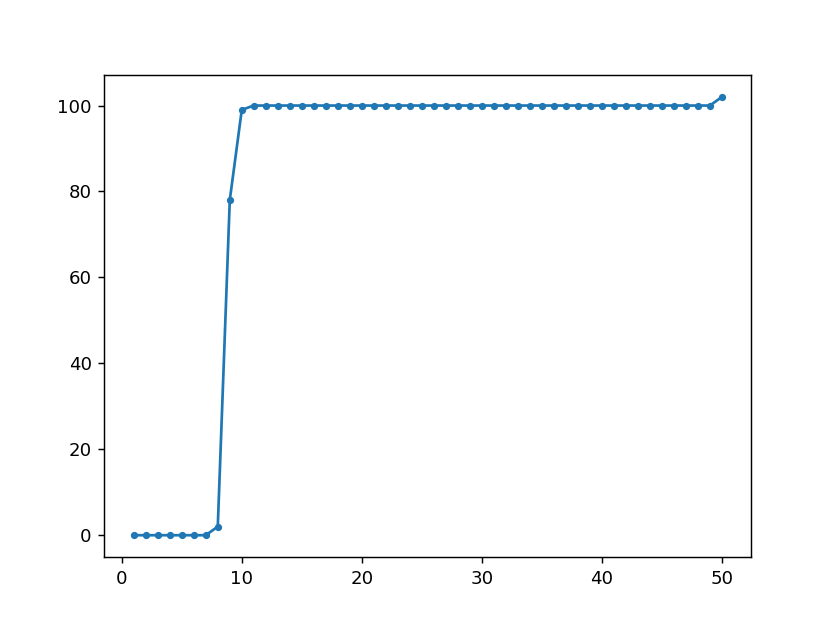

In [9]:
idb_dac = 0

idb = chip.set_idb_dacunits(idb_dac, 1)
chip.write_conf()

for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
    
injlist = np.arange(50, 0, -1)
inj_low_dac = chip.get_vl_dacunits()
cnt = np.empty(len(injlist))
print "inj all_hits hits aveToT"
for inj_i, inj in enumerate(injlist):
    inj_high_pulse_dac = inj + inj_low_dac
    inj_high_pulse = chip.set_vh_dacunits(inj_high_pulse_dac, 0)
    chip.write_conf()

    for _ in range(5):
        chip['fifo'].reset()
        time.sleep(0.002)
    chip.set_monoread()
    chip["inj"].start()
    while not chip['inj'].is_ready:
        time.sleep(0.001)
    time.sleep(0.2)
    
    ix_inj = ix[np.bitwise_and(ix["col"]==col_to_inject, ix["row"]==row_to_inject)]
    print inj, len(ix), len(ix_inj), np.average((ix_inj["te"]-ix_inj["le"]) & 0x3F)
    cnt[inj_i] = len(ix_inj)
plot.scatter_plot(injlist, cnt, 'injlist[DAC]', '#', dx = None, dy = None,  title = '', legend = '', fmt='.')

## run threshold scan using injection_scan

In [10]:

#chip.set_vh_dacunits(54,1)
#chip.set_idb_dacunits(0,1)

import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

pix=[3, col_to_inject, row_to_inject]
#injlist=np.arange(73,0,-1)
thlist= None #np.arange(80,20,-1)
phaselist=None
output_filename=scans.start(
        pix=pix,
        injlist=injlist,thlist=thlist,phaselist=phaselist,
        with_mon=False,n_mask_pix=1,debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
with tb.open_file(fev) as f:
    hits=f.root.Hits[:]
print len(hits)

uni,u_cnt=np.unique(hits["inj"],return_counts=True)
data=np.zeros(len(injlist))
for u_i,u in enumerate(uni):
    a=np.argmin(np.abs(injlist-u))
    data[a]=u_cnt[u_i]
plt.plot(injlist,data,"C1o",label="fast scan")
plt.plot(injlist,cnt,"C0.-",label="step by step") ### step by step
plt.legend()

2022-01-31 12:18:26,592 [INFO ] (MainThread) Initializing InjectionScan
2022-01-31 12:18:27,256 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 78.01324044508196, 'VDDD [V]': 1.8005150383838384, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.062780289971045, 'VDDD OC': False, 'VPC [mA]': 0.07949965508295424, 'VPCSWSF [mA]': -0.030515135468720558, 'VDDA [V]': 1.8038584294294295, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8045472377622378, 'BiasSF [mA]': 0.10059447096451782}
2022-01-31 12:18:32,690 [INFO ] (MainThread) Temperature (C): 29.082577
2022-01-31 12:18:32,736 [INFO ] (MainThread) Temperature (C): 29.082577
2022-01-31 12:18:32,790 [INFO ] (MainThread) Temperature (C): 28.913018
2022-01-31 12:18:32,838 [INFO ] (MainThread) Temperature (C): 28.893546
2022-01-31 12:18:32,891 [INF

KeyError: 'collist'

# Global TH scan

In [82]:
20.3439450687*10

203.43945068699998

2019-04-04 05:32:22,735 [INFO ] (MainThread) Initializing InjectionScan
2019-04-04 05:32:23,214 [INFO ] (MainThread) power status: {'VPC [V]': 0.8968192194291438, 'VDDA_DAC [mA]': 567.1670178167402, 'VDDP [V]': 1.7913174844533601, 'VDDD [V]': 1.7921228324974925, 'VDDA [mA]': 577.0899264452138, 'VPC [mA]': -0.32002818589178506, 'VDDD [mA]': 569.4866960087318, 'VPCSWSF [V]': 0.8973983967065867, 'VDDP [mA]': 575.548350884382, 'BiasSF [V]': 0.8971388147553919, 'VPCSWSF [mA]': -0.32130961215949544, 'VDDA [V]': 1.7921857260956175, 'VDDA_DAC [V]': 1.7915526135458166, 'BiasSF [mA]': -0.32389637762237766}
2019-04-04 05:32:23,295 [INFO ] (MainThread) Creating ZMQ context
2019-04-04 05:32:23,296 [INFO ] (MainThread) Creating socket connection to server tcp://127.0.0.1:5500
2019-04-04 05:32:23,297 [INFO ] (MainThread) ScanBase.start:data_send.data_send_init connected
2019-04-04 05:32:23,299 [INFO ] (MainThread) Resetting SRAM FIFO: size = 0
2019-04-04 05:32:23,767 [INFO ] (MainThread) Set timestam

0 11063 100.000% 1554348746.470s 3541hits 0errs
data (inj_n 100,inj_loop 31): INJ=3100 MONO=441 MON=0
0 3541 100.000% 0.001s 441hits 0errs
441 441
gl_th 4


<IPython.core.display.Javascript object>


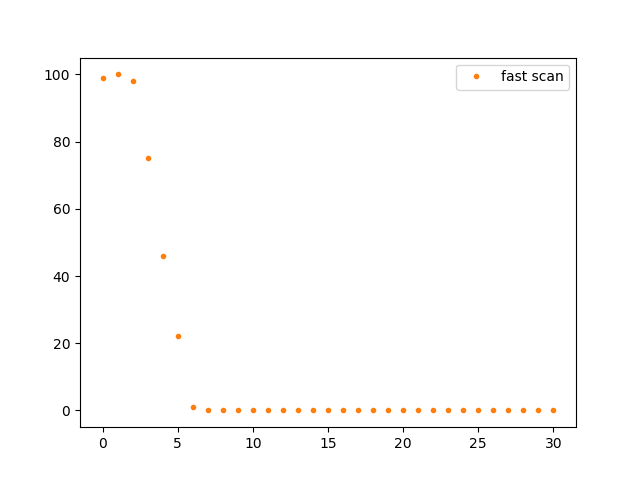

In [86]:
chip.set_vl_dacunits(40,0)
chip.set_vh_dacunits(10+40,0)
chip.write_conf()

for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)

thlist=np.arange(30,-1,-1)

## step by step 
if False:
    cnt=np.empty(len(thlist))
    print "inj all_hits hits aveToT"
    for th_i,th in enumerate(thlist):
        chip.set_idb_dacunits(th,0)
        chip.write_conf()
        for _ in range(5):
            chip['fifo'].reset()
            time.sleep(0.002)
        chip.set_monoread()
        chip["inj"].start()
        while not chip['inj'].is_ready:
            time.sleep(0.001)
        time.sleep(0.2)
        x = chip['fifo'].get_data()
        ix = chip.interpret_data(x)
        ix_inj=ix[np.bitwise_and(ix["col"]==col_to_inject, ix["row"]==row_to_inject)]
        print th,len(ix),len(ix_inj),np.average((ix_inj["te"]-ix_inj["le"]) & 0x3F)
        cnt[th_i]=len(ix_inj)
    plt.plot(thlist,cnt,"C0.-",label="step by step")
    
## fast scan
pix=[3, col_to_inject, row_to_inject]
injlist=None
#thlist=np.arange(80,20,-1)
phaselist=None
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)
output_filename=scans.start(
        pix=pix,
        injlist=injlist,thlist=thlist,phaselist=phaselist,
        with_mon=False,n_mask_pix=1,debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
with tb.open_file(fev) as f:
    hits=f.root.Hits[:]
print len(hits),
hits=hits[np.bitwise_and(hits["col"]==col_to_inject,hits["row"]==row_to_inject)]
print len(hits)

uni,u_cnt=np.unique(hits["th"],return_counts=True)
data=np.zeros(len(thlist))
for u_i,u in enumerate(uni):
    a=np.argmin(np.abs(thlist-u))
    data[a]=u_cnt[u_i]
gl_th=thlist[np.argmin(np.abs(data-50))]
print "gl_th",gl_th
plt.plot(thlist,data,"C1.",label="fast scan")
plt.legend()

# phase scan

2019-04-04 05:33:38,676 [INFO ] (MainThread) Initializing InjectionScan
2019-04-04 05:33:39,163 [INFO ] (MainThread) power status: {'VPC [V]': 0.8968192194291438, 'VDDA_DAC [mA]': 567.1670178167402, 'VDDP [V]': 1.7913174844533601, 'VDDD [V]': 1.7921228324974925, 'VDDA [mA]': 577.0899264452138, 'VPC [mA]': -0.32002818589178506, 'VDDD [mA]': 569.4866960087318, 'VPCSWSF [V]': 0.8973983967065867, 'VDDP [mA]': 575.548350884382, 'BiasSF [V]': 0.8971388147553919, 'VPCSWSF [mA]': -0.32130961215949544, 'VDDA [V]': 1.7921857260956175, 'VDDA_DAC [V]': 1.7915526135458166, 'BiasSF [mA]': -0.32389637762237766}
2019-04-04 05:33:39,247 [INFO ] (MainThread) Creating ZMQ context
2019-04-04 05:33:39,248 [INFO ] (MainThread) Creating socket connection to server tcp://127.0.0.1:5500
2019-04-04 05:33:39,249 [INFO ] (MainThread) ScanBase.start:data_send.data_send_init connected
2019-04-04 05:33:39,251 [INFO ] (MainThread) Resetting SRAM FIFO: size = 0
2019-04-04 05:33:39,700 [INFO ] (MainThread) Set timestam

0 33599 100.000% 1554348822.988s 9600hits 0errs
data (inj_n 100,inj_loop 48): INJ=4800 MONO=4800 MON=0
0 9600 100.000% 0.002s 4800hits 0errs
AnalyzeHits: le_cnts will be analyzed
toa [11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12]
toa [100 100 100 100 100  99   1 100 100 100 100 100 100 100 100 100 100 100
 100 100]
AnalyzeLECnts: n of LECounts 50
save_best_phase() number of LEhist 1
========= save_best_phase() [18 25] phase=6 le=12


<IPython.core.display.Javascript object>


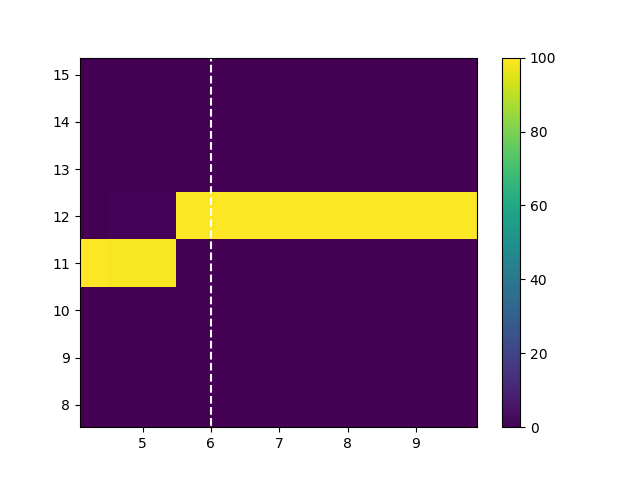

In [88]:
#gl_th=4 ## from gl_th scan
chip.set_vl_dacunits(40,0)
chip.set_vh_dacunits(80+40,0)
chip.set_idb_dacunits(gl_th,0)
chip.write_conf()

pix=[3, col_to_inject, row_to_inject]
injlist=None
thlist= None
phaselist=np.arange(0,48,1)
import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)
output_filename=scans.start(
        pix=pix,
        injlist=injlist,thlist=thlist,phaselist=phaselist,
        with_mon=False,n_mask_pix=1,debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
fraw=scans.output_filename+".h5"
import tjmonopix.analysis.analyze_hits as analyze_hits
ana=analyze_hits.AnalyzeHits(fev,fraw)
ana.init_hist_ev()
ana.init_cnts()
ana.init_le_hist()
ana.init_le_cnts()
ana.run()

import tjmonopix.analysis.analyze_le_cnts as analyze_le_cnts
ana=analyze_le_cnts.AnalyzeLECnts(fev,fraw)
ana.init_best_phase()
ana.run()
with tb.open_file(fev) as f:
    phase=f.root.BestPhase[0]["phase"]
with tb.open_file(fev) as f:
    hits=f.root.LEHist[:]
plt.imshow(np.transpose(hits[0]["LE"]),origin="bottom left",aspect="auto")
plt.plot([phase,phase],[0,63],"w--")
plt.ylim(0,63)
plt.colorbar()

In [90]:
#gl_th=4
#phase=6
chip.set_vl_dacunits(40,0)
chip.set_idb_dacunits(gl_th,0)
chip.write_conf()
chip["inj"].set_phase(phase)

import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

pix=[3, col_to_inject, row_to_inject]
injlist=np.arange(1,80,1)
thlist= None #np.arange(80,20,-1)
phaselist=None
output_filename=scans.start(
        pix=pix,
        injlist=injlist,thlist=thlist,phaselist=phaselist,
        with_mon=False,n_mask_pix=1,debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
fraw=scans.output_filename+".h5"
import tjmonopix.analysis.analyze_hits as analyze_hits
reload(analyze_hits)
ana=analyze_hits.AnalyzeHits(fev,fraw)
ana.init_apply_ts_inj_window()
ana.init_delete_noninjected()
ana.init_hist_ev()
ana.init_cnts()
ana.init_le_hist()
ana.init_le_cnts()
ana.run()

import tjmonopix.analysis.analyze_cnts as analyze_cnts
ana=analyze_cnts.AnalyzeCnts(fev,fraw)
ana.init_scurve_fit()
ana.run()

import tjmonopix.analysis.analyze_le_cnts as analyze_le_cnts
reload(analyze_le_cnts)
ana=analyze_le_cnts.AnalyzeLECnts(fev,fraw)
ana.init_scurve_fit()
ana.run()

2019-04-04 05:37:09,840 [INFO ] (MainThread) Initializing InjectionScan
2019-04-04 05:37:10,329 [INFO ] (MainThread) power status: {'VPC [V]': 0.8968192194291438, 'VDDA_DAC [mA]': 567.1670178167402, 'VDDP [V]': 1.7913174844533601, 'VDDD [V]': 1.7921228324974925, 'VDDA [mA]': 577.0899264452138, 'VPC [mA]': -0.32002818589178506, 'VDDD [mA]': 569.4866960087318, 'VPCSWSF [V]': 0.8973983967065867, 'VDDP [mA]': 575.548350884382, 'BiasSF [V]': 0.8971388147553919, 'VPCSWSF [mA]': -0.32130961215949544, 'VDDA [V]': 1.7921857260956175, 'VDDA_DAC [V]': 1.7915526135458166, 'BiasSF [mA]': -0.32389637762237766}
2019-04-04 05:37:10,414 [INFO ] (MainThread) Creating ZMQ context
2019-04-04 05:37:10,415 [INFO ] (MainThread) Creating socket connection to server tcp://127.0.0.1:5500
2019-04-04 05:37:10,416 [INFO ] (MainThread) ScanBase.start:data_send.data_send_init connected
2019-04-04 05:37:10,418 [INFO ] (MainThread) Resetting SRAM FIFO: size = 0
2019-04-04 05:37:10,881 [INFO ] (MainThread) Set timestam

2019-04-04 05:37:14,477 [INFO ] (MainThread) Data queue size: 0
2019-04-04 05:37:14,485 [INFO ] (MainThread) SRAM FIFO size: 0
2019-04-04 05:37:14,491 [INFO ] (MainThread) Channel:                     TDC | DATA_RX | TLU | TIMESTAMP
2019-04-04 05:37:14,493 [INFO ] (MainThread) Discard counter:             None |       0 |   0 |         0
2019-04-04 05:37:14,998 [INFO ] (MainThread) Power status: {'VPC [V]': 0.8968192194291438, 'VDDA_DAC [mA]': 567.1670178167402, 'VDDP [V]': 1.7913174844533601, 'VDDD [V]': 1.7921228324974925, 'VDDA [mA]': 577.0899264452138, 'VPC [mA]': -0.32002818589178506, 'VDDD [mA]': 569.4866960087318, 'VPCSWSF [V]': 0.8973983967065867, 'VDDP [mA]': 575.548350884382, 'BiasSF [V]': 0.8971388147553919, 'VPCSWSF [mA]': -0.32130961215949544, 'VDDA [V]': 1.7921857260956175, 'VDDA_DAC [V]': 1.7915526135458166, 'BiasSF [mA]': -0.32389637762237766}
2019-04-04 05:37:15,075 [INFO ] (MainThread) Closing socket connection


0 51443 100.000% 1554349035.087s 14836hits 0errs
data (inj_n 100,inj_loop 79): INJ=7900 MONO=6936 MON=0
0 14836 100.000% 0.002s 6934hits 0errs
AnalyzeHits: le_cnts will be analyzed
AnalyzeLECnts: n of LECounts 74
### Fit scurves ###
79 13 11


/home/user/workspace/tjmonopix/tjmonopix_bell/tjmonopix/analysis/utils.py:77: RuntimeWarning: invalid value encountered in sqrt
  err=np.sqrt(np.diag(cov))


<IPython.core.display.Javascript object>


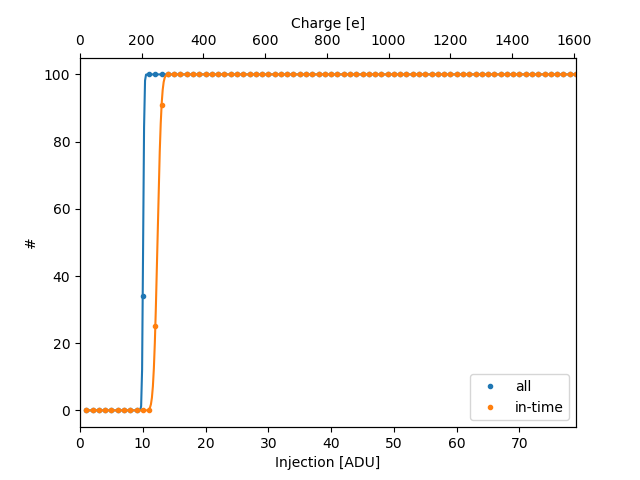

all mu 10.059 ADU (204.65 e) sigma 0.144 ADU (2.93 e)
intime mu 12.335 ADU (250.94 e) sigma 0.496 ADU (10.08 e)
over drive 2.275 ADU (46.29 e)


In [112]:
with tb.open_file(fev) as f:
    le=f.root.LECnts[:]
    le_fit=f.root.LEScurveFit[:]
    cnt=f.root.Cnts[:]
    cnt_fit=f.root.ScurveFit[:]
fig,ax=plt.subplots(1,1)
import tjmonopix.analysis.utils as utils
x=np.append(np.arange(1,np.min(cnt["inj"])),cnt["inj"])
y=np.append(np.zeros(len(x)-len(cnt["cnt"])),cnt["cnt"])
ax.plot(x,y,"C0.",label="all")
A=cnt_fit[0]["A"]
mu=cnt_fit[0]["mu"]
sigma=cnt_fit[0]["sigma"]
x,y=utils.scurve_from_fit(x,A_fit=A,mu_fit=mu,sigma_fit=sigma,reverse=False)
ax.plot(x,y,"C0-")
print "all mu %.3f ADU (%.2f e) sigma %.3f ADU (%.2f e)"%(mu,mu*CAPCAL,sigma,sigma*CAPCAL)

tmp=le[le["toa"]==12]
x=np.append(np.arange(1,np.min(tmp["inj"])),tmp["inj"])
y=np.append(np.zeros(len(x)-len(tmp["cnt"])),tmp["cnt"])
ax.plot(x,y,"C1.",label="in-time")
A=le_fit[le_fit["toa"]==12][0]["A"]
mu_in=le_fit[le_fit["toa"]==12][0]["mu"]
sigma_in=le_fit[le_fit["toa"]==12][0]["sigma"]
x,y=utils.scurve_from_fit(x,A_fit=A,mu_fit=mu_in,sigma_fit=sigma_in,reverse=False)
ax.plot(x,y,"C1-")
ax.set_xbound(0,np.max(cnt["inj"]))
ax2=ax.twiny()
ax2.set_xbound(0,np.max(cnt["inj"])*CAPCAL)
ax.set_xlabel("Injection [ADU]")
ax2.set_xlabel("Charge [e]")
ax.set_ylabel("#")
print "intime mu %.3f ADU (%.2f e) sigma %.3f ADU (%.2f e)"%(mu_in,mu_in*CAPCAL,sigma_in,sigma_in*CAPCAL)
print "over drive %.3f ADU (%.2f e)"%(mu_in-mu, (mu_in-mu)*CAPCAL)
ax.legend()